# PSB injection bump in Xsuite - time dependent functions

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

###  Load line from previous notebook

In [3]:
# Reload
line = xt.Line.from_json('psb_01_with_chicane.json')
line.build_tracker()

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Read time dependence of bsw_k0l and bsw_k2l from file (using pandas) 

In [6]:
df = pd.read_csv('chicane_collapse.csv', delimiter=',', skipinitialspace=True)

In [7]:
df.head()

,time,bsw_k0l,bsw_k2l
0,0.0000,0.066000,0.000000
1,0.0001,0.065901,-0.012179
2,0.0002,0.065605,-0.024357
3,0.0003,0.065113,-0.036536
4,0.0004,0.064425,-0.048714


### Build piece-wise linear functions using the loaded table

These are basically linear interpolators (outside the defined range they hold the last point)

In [8]:
line.functions['fun_bsw_k0l'] = xd.FunctionPieceWiseLinear(x=df['time'].values, y=df['bsw_k0l'].values)
line.functions['fun_bsw_k2l'] = xd.FunctionPieceWiseLinear(x=df['time'].values, y=df['bsw_k2l'].values)

### Define time-dependent knobs

Xtrack provides the variable `t_turn_s` which is automatically updated during tracking and can be used to define time-dependent functions.

In [9]:
line.vars['bsw_k0l'] = line.functions.fun_bsw_k0l(line.vars['t_turn_s']) 
line.vars['bsw_k2l'] = line.functions.fun_bsw_k2l(line.vars['t_turn_s'])                 

We can make it more flexibles to by adding variables to switch on/off the time-dependence

In [10]:
line.vars['on_chicane_k0'] = 1
line.vars['on_chicane_k2'] = 1
line.vars['bsw_k0l'] = line.functions.fun_bsw_k0l(line.vars['t_turn_s'] * line.vars['on_chicane_k0'])
line.vars['bsw_k2l'] = line.functions.fun_bsw_k2l(line.vars['t_turn_s'] * line.vars['on_chicane_k2'])

### Check the line behavior

In [22]:
t_test = np.linspace(0, 6e-3, 100)

k0_bsw1 = []
k2l_bsw1 = []
k0_bsw2 = []
k2l_bsw2 = []
qx = []
qy = []
x_at_foil = []
bety_at_qde3 = []

for ii, tt in enumerate(t_test):
    
    line.vars['t_turn_s'] = tt # Set the test time

    print(f'Twiss at t = {tt*1e3:.2f} ms   ', end='\r', flush=True)
    tw = line.twiss()

    qx.append(tw.qx)
    qy.append(tw.qy)
    bety_at_qde3.append(tw['bety', 'br.qde3'])
    x_at_foil.append(tw['x', 'bi1.tstr1l1'])
    
    k0_bsw1.append(line['bi1.bsw1l1.1'].k0)
    k2l_bsw1.append(line['bi1.bsw1l1.1'].knl[2])
    k0_bsw2.append(line['bi1.bsw1l1.2'].k0)
    k2l_bsw2.append(line['bi1.bsw1l1.2'].knl[2])

<IPython.core.display.Javascript object>


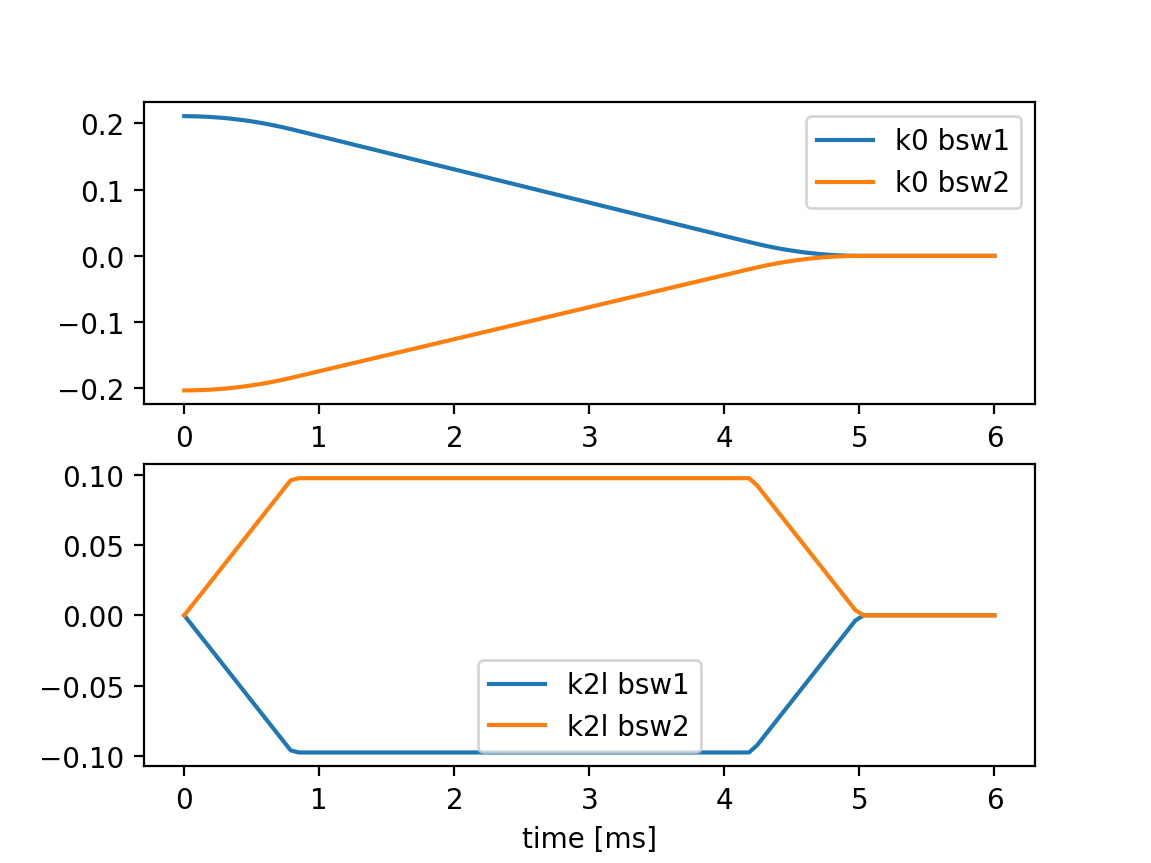

Text(0.5, 0, 'time [ms]')

In [23]:
plt.figure(1, figsize=(6.4*0.9, 4.8*0.9))
sp1 = plt.subplot(2,1,1)
plt.plot(t_test*1e3, k0_bsw1, label='k0 bsw1')
plt.plot(t_test*1e3, k0_bsw2, label='k0 bsw2')
plt.legend()
plt.subplot(2,1,2, sharex=sp1)
plt.plot(t_test*1e3, k2l_bsw1, label='k2l bsw1')
plt.plot(t_test*1e3, k2l_bsw2, label='k2l bsw2')
plt.legend()
plt.xlabel('time [ms]')

<IPython.core.display.Javascript object>


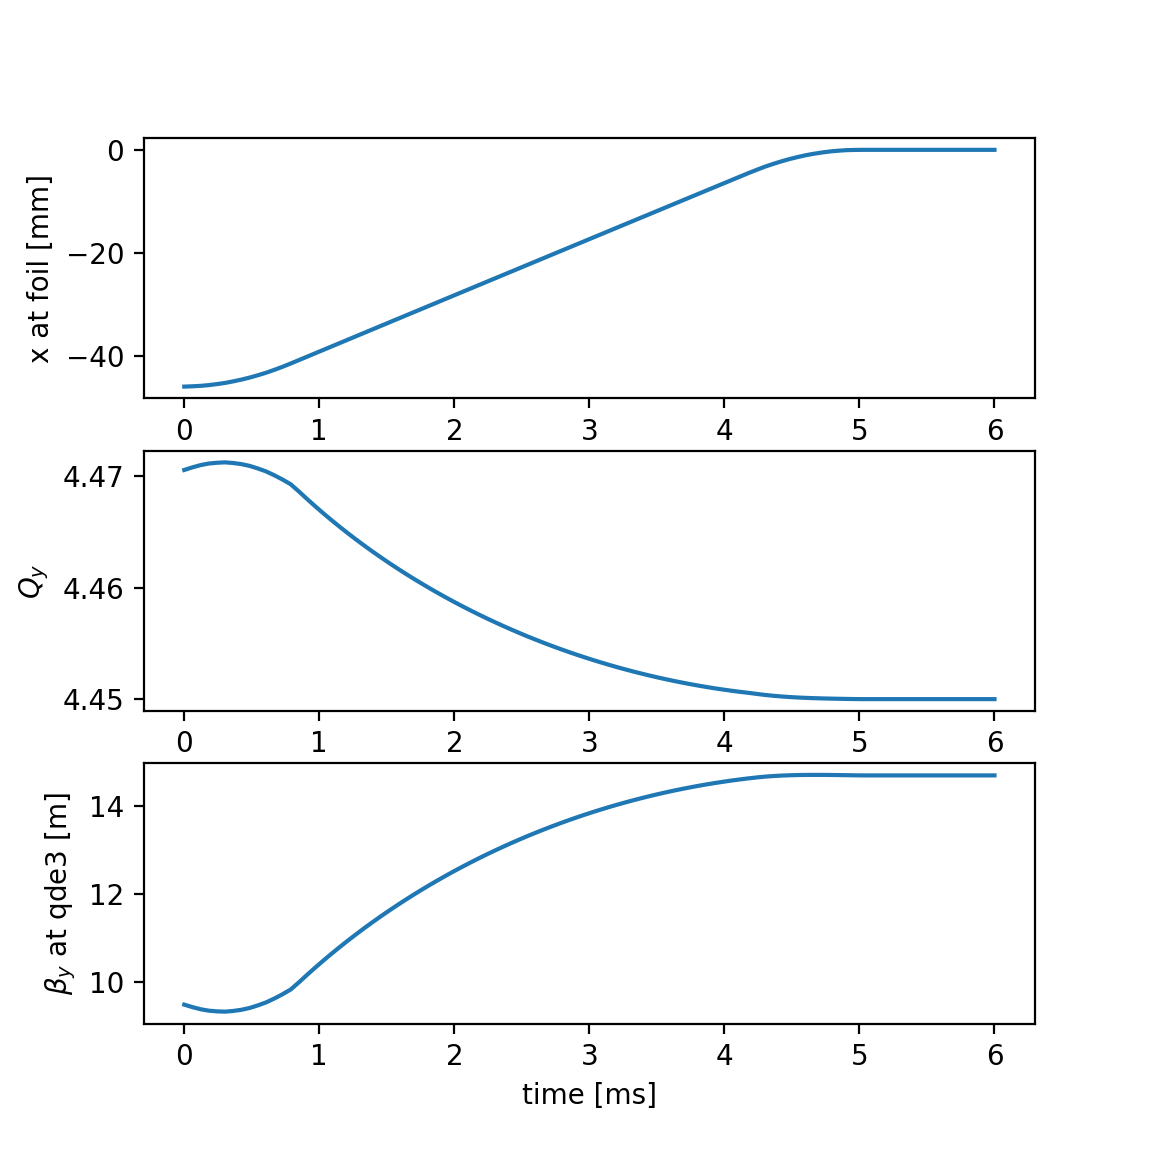

Text(0.5, 0, 'time [ms]')

In [27]:
plt.figure(2, figsize=(6.4*0.9, 4.8*1.2))

sp1 = plt.subplot(3,1,1, sharex=sp1)
plt.plot(t_test*1e3, np.array(x_at_foil)*1e3, label='x at foil')
plt.ylabel('x at foil [mm]')

sp2 = plt.subplot(3,1,2, sharex=sp1)
plt.plot(t_test*1e3, qy, label='qy')
plt.ylabel(r'$Q_y$')

sp3 = plt.subplot(3,1,3, sharex=sp1)
plt.plot(t_test*1e3, bety_at_qde3, label='bety at qde3')
plt.ylabel(r'$\beta_y$ at qde3 [m]')
plt.xlabel('time [ms]')


### Save line

In [28]:
line.to_json('psb_02_with_chicane_time_functions.json')

---------